In [24]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import (
    BertTokenizer, 
    BertModel, 
    AutoTokenizer, 
    AutoModel, 
    AutoConfig, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch.nn as nn


In [25]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

label2id = {"contradiction": 0, "entailment": 1, "neutral": 2}

class CustomDebertaClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.1):
        super(CustomDebertaClassifier, self).__init__()
        # 載入預訓練配置與模型
        self.config = AutoConfig.from_pretrained(model_name)
        self.deberta = AutoModel.from_pretrained(model_name, config=self.config)
        # Freeze the DeBERTa base model (transfer learning: only fine-tune FC)
        for param in self.deberta.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # 取 [CLS] token 的 representation (pooler_output)
        pooled_output = outputs[0][:, 0]
        pooled_output = self.dropout(pooled_output)
        hidden = self.fc1(pooled_output)
        hidden = self.relu(hidden)
        logits = self.fc2(hidden)

        output = {"logits": logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            output["loss"] = loss
        return output

In [26]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("SICK.txt", sep="\t")
# 保留所需欄位
df = df[["sentence_A", "sentence_B", "entailment_label"]]
print("原始資料形狀:", df.shape)
# 將標籤轉小寫，再映射成數值
df["entailment_label"] = df["entailment_label"].str.lower()
df["entailment_label"] = df["entailment_label"].map(label2id)

# 使用 stratified split 分 80%/20%
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["entailment_label"], random_state=42
)
print("訓練集形狀:", train_df.shape, "測試集形狀:", test_df.shape)

原始資料形狀: (9840, 3)
訓練集形狀: (7872, 3) 測試集形狀: (1968, 3)


In [29]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence_A"],
        examples["sentence_B"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

model_name = "tasksource/deberta-small-long-nli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

def rename_label(example):
    example["labels"] = example["entailment_label"]
    return example

train_dataset = train_dataset.map(rename_label)
test_dataset = test_dataset.map(rename_label)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
num_labels = len(label2id)
results = {}

Map: 100%|██████████| 1968/1968 [00:00<00:00, 21060.34 examples/s]



使用訓練資料數量: 20 筆
Fold 1


Map:   0%|          | 0/2624 [00:00<?, ? examples/s]

Map: 100%|██████████| 2624/2624 [00:00<00:00, 23760.94 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.885200,1.009327,0.559070
2,1.054900,0.986283,0.582317
3,1.047400,0.965972,0.604421
4,1.071400,0.947352,0.621951
5,0.994700,0.930220,0.632241
6,1.027500,0.914534,0.642530
7,1.179500,0.899958,0.653201
8,0.657800,0.887011,0.658537
9,0.720000,0.875464,0.662729
10,0.686700,0.865298,0.665777


資料數量 20 的 Fold 1 Evaluation results: {'eval_loss': 0.8172830939292908, 'eval_accuracy': 0.6756859756097561, 'eval_runtime': 12.9955, 'eval_samples_per_second': 201.916, 'eval_steps_per_second': 6.31, 'epoch': 20.0}
分類報告 (Train Subset 20, Fold 1):
               precision    recall  f1-score   support

contradiction       0.91      0.88      0.90       285
   entailment       1.00      0.01      0.01       564
      neutral       0.65      0.98      0.78      1119

     accuracy                           0.69      1968
    macro avg       0.85      0.62      0.56      1968
 weighted avg       0.79      0.69      0.58      1968

Confusion Matrix (Train Subset 20, Fold 1):
[[ 251    0   34]
 [   1    3  560]
 [  23    0 1096]]


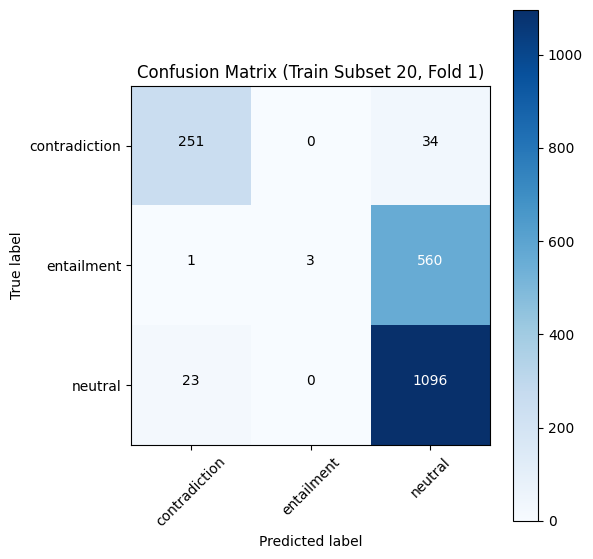

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24775.18 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.908100,0.984374,0.526296
2,0.936100,0.956811,0.592607
3,0.978300,0.934068,0.648628
4,0.815500,0.913614,0.705030
5,0.999400,0.894820,0.738948
6,0.862600,0.877725,0.774771
7,0.742100,0.862249,0.790015
8,0.905600,0.847961,0.797637
9,0.770300,0.834954,0.805259
10,0.946200,0.823460,0.815930


資料數量 20 的 Fold 2 Evaluation results: {'eval_loss': 0.7703408002853394, 'eval_accuracy': 0.8391768292682927, 'eval_runtime': 12.966, 'eval_samples_per_second': 202.375, 'eval_steps_per_second': 6.324, 'epoch': 20.0}
分類報告 (Train Subset 20, Fold 2):
               precision    recall  f1-score   support

contradiction       0.65      0.94      0.77       285
   entailment       0.94      0.80      0.87       564
      neutral       0.88      0.85      0.87      1119

     accuracy                           0.85      1968
    macro avg       0.83      0.86      0.83      1968
 weighted avg       0.87      0.85      0.85      1968

Confusion Matrix (Train Subset 20, Fold 2):
[[268   1  16]
 [  2 451 111]
 [141  26 952]]


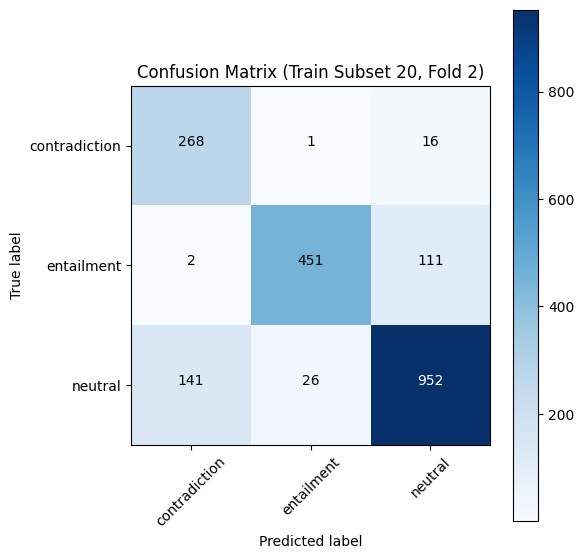

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24901.08 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.129300,0.979314,0.560595
2,1.122200,0.950876,0.647485
3,0.921000,0.925466,0.737424
4,0.948700,0.901764,0.785823
5,0.937500,0.880017,0.822027
6,0.882100,0.860560,0.842607
7,0.861400,0.843297,0.853659
8,0.928200,0.828000,0.863186
9,0.751700,0.814126,0.868521
10,0.795600,0.801319,0.876524


資料數量 20 的 Fold 3 Evaluation results: {'eval_loss': 0.7410064339637756, 'eval_accuracy': 0.8879573170731707, 'eval_runtime': 13.2769, 'eval_samples_per_second': 197.637, 'eval_steps_per_second': 6.176, 'epoch': 20.0}
分類報告 (Train Subset 20, Fold 3):
               precision    recall  f1-score   support

contradiction       0.86      0.89      0.88       285
   entailment       0.90      0.85      0.87       564
      neutral       0.90      0.92      0.91      1119

     accuracy                           0.89      1968
    macro avg       0.89      0.89      0.89      1968
 weighted avg       0.89      0.89      0.89      1968

Confusion Matrix (Train Subset 20, Fold 3):
[[ 255    1   29]
 [   1  479   84]
 [  41   53 1025]]


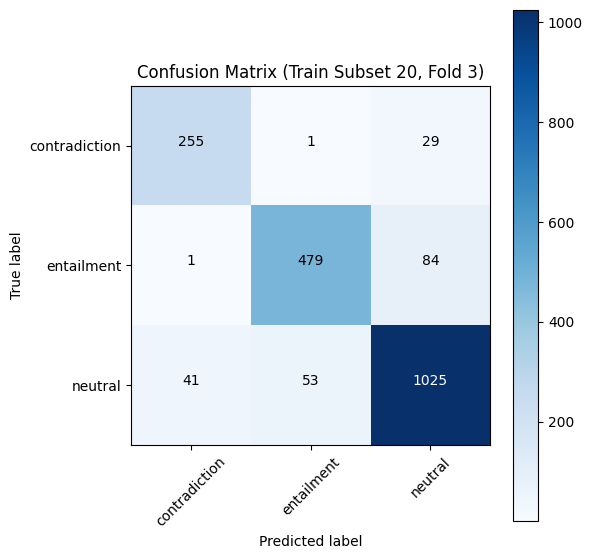


使用訓練資料數量: 50 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 18636.02 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.097500,0.951933,0.603659
2,0.896500,0.896097,0.742759
3,1.027200,0.848772,0.816692
4,0.782700,0.807693,0.847561
5,0.741700,0.772565,0.867759
6,0.853900,0.740528,0.876905
7,0.764400,0.711652,0.885290
8,0.729600,0.685682,0.891768
9,1.165200,0.662993,0.898247
10,1.041600,0.644393,0.902820


資料數量 50 的 Fold 1 Evaluation results: {'eval_loss': 0.563446581363678, 'eval_accuracy': 0.9051067073170732, 'eval_runtime': 12.9125, 'eval_samples_per_second': 203.214, 'eval_steps_per_second': 6.35, 'epoch': 20.0}
分類報告 (Train Subset 50, Fold 1):
               precision    recall  f1-score   support

contradiction       0.86      0.92      0.89       285
   entailment       0.91      0.86      0.88       564
      neutral       0.91      0.92      0.91      1119

     accuracy                           0.90      1968
    macro avg       0.89      0.90      0.89      1968
 weighted avg       0.90      0.90      0.90      1968

Confusion Matrix (Train Subset 50, Fold 1):
[[ 261    1   23]
 [   1  486   77]
 [  42   49 1028]]


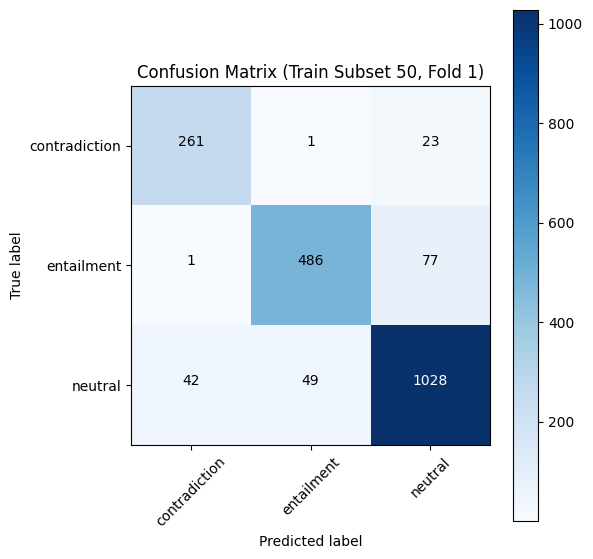

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23665.45 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.070400,0.948801,0.613948
2,0.799600,0.892222,0.735518
3,0.736500,0.844054,0.806402
4,0.819100,0.802803,0.837652
5,0.738700,0.767666,0.854421
6,0.673300,0.735283,0.865854
7,0.662000,0.706492,0.870808
8,0.470300,0.682382,0.876143
9,0.700200,0.661106,0.879954
10,0.586800,0.642585,0.884909


資料數量 50 的 Fold 2 Evaluation results: {'eval_loss': 0.5624684691429138, 'eval_accuracy': 0.8971036585365854, 'eval_runtime': 12.8173, 'eval_samples_per_second': 204.723, 'eval_steps_per_second': 6.398, 'epoch': 20.0}
分類報告 (Train Subset 50, Fold 2):
               precision    recall  f1-score   support

contradiction       0.89      0.88      0.89       285
   entailment       0.95      0.80      0.87       564
      neutral       0.88      0.95      0.92      1119

     accuracy                           0.90      1968
    macro avg       0.91      0.88      0.89      1968
 weighted avg       0.90      0.90      0.90      1968

Confusion Matrix (Train Subset 50, Fold 2):
[[ 252    1   32]
 [   1  452  111]
 [  29   23 1067]]


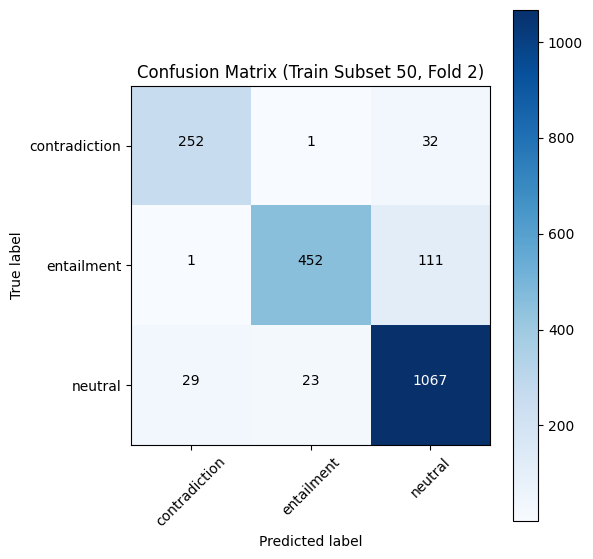

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23931.49 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949500,0.951221,0.662729
2,0.952100,0.896695,0.798780
3,0.855300,0.848624,0.859375
4,0.960000,0.807775,0.879954
5,0.901400,0.771968,0.888720
6,0.762000,0.739990,0.893293
7,0.622400,0.711306,0.896341
8,0.753600,0.685871,0.895960
9,0.820700,0.664350,0.897104
10,0.739000,0.645765,0.896723


資料數量 50 的 Fold 3 Evaluation results: {'eval_loss': 0.5689528584480286, 'eval_accuracy': 0.8902439024390244, 'eval_runtime': 12.9707, 'eval_samples_per_second': 202.302, 'eval_steps_per_second': 6.322, 'epoch': 20.0}
分類報告 (Train Subset 50, Fold 3):
               precision    recall  f1-score   support

contradiction       0.95      0.74      0.83       285
   entailment       0.90      0.88      0.89       564
      neutral       0.88      0.94      0.91      1119

     accuracy                           0.89      1968
    macro avg       0.91      0.85      0.88      1968
 weighted avg       0.89      0.89      0.89      1968

Confusion Matrix (Train Subset 50, Fold 3):
[[ 211    1   73]
 [   1  494   69]
 [  11   56 1052]]


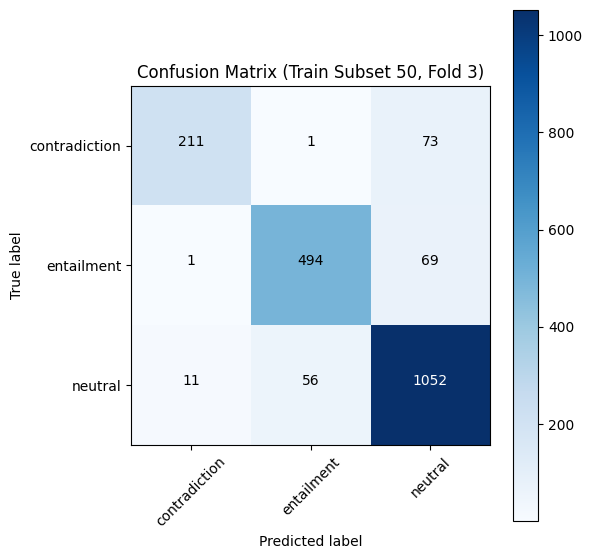


使用訓練資料數量: 70 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23180.08 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.980000,0.934040,0.649009
2,0.918900,0.862926,0.796494
3,0.875200,0.802094,0.847180
4,0.765700,0.749181,0.872713
5,0.768000,0.703668,0.881860
6,0.760800,0.663728,0.891387
7,0.901400,0.629988,0.894055
8,0.578500,0.602675,0.899009
9,0.670200,0.578876,0.902439
10,0.685800,0.558284,0.902439


資料數量 70 的 Fold 1 Evaluation results: {'eval_loss': 0.4727940559387207, 'eval_accuracy': 0.9115853658536586, 'eval_runtime': 12.9043, 'eval_samples_per_second': 203.344, 'eval_steps_per_second': 6.354, 'epoch': 20.0}
分類報告 (Train Subset 70, Fold 1):
               precision    recall  f1-score   support

contradiction       0.91      0.88      0.90       285
   entailment       0.92      0.86      0.89       564
      neutral       0.90      0.94      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 70, Fold 1):
[[ 252    1   32]
 [   1  484   79]
 [  25   42 1052]]


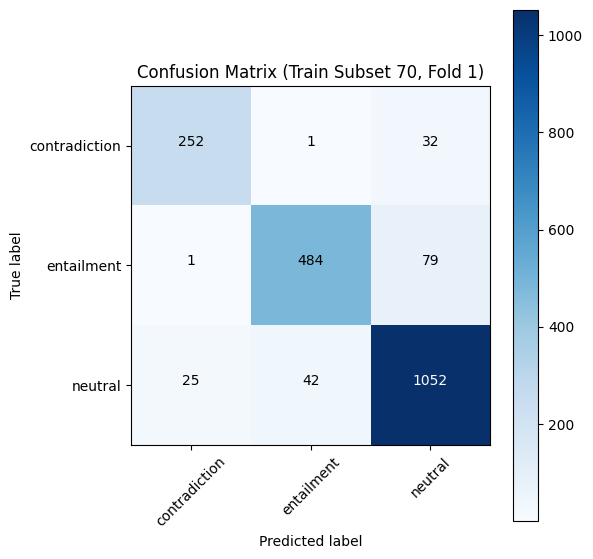

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24320.13 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.083600,0.944306,0.674543
2,0.888400,0.874683,0.804878
3,0.906300,0.813606,0.858994
4,0.834000,0.760442,0.877668
5,0.680100,0.714578,0.887576
6,0.756500,0.674832,0.893674
7,0.795300,0.641270,0.896341
8,0.664300,0.612146,0.898628
9,0.690400,0.587132,0.901296
10,0.688000,0.566383,0.900534


資料數量 70 的 Fold 2 Evaluation results: {'eval_loss': 0.4841883182525635, 'eval_accuracy': 0.9024390243902439, 'eval_runtime': 13.3815, 'eval_samples_per_second': 196.092, 'eval_steps_per_second': 6.128, 'epoch': 20.0}
分類報告 (Train Subset 70, Fold 2):
               precision    recall  f1-score   support

contradiction       0.93      0.87      0.90       285
   entailment       0.91      0.86      0.88       564
      neutral       0.90      0.94      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 70, Fold 2):
[[ 249    1   35]
 [   1  487   76]
 [  19   50 1050]]


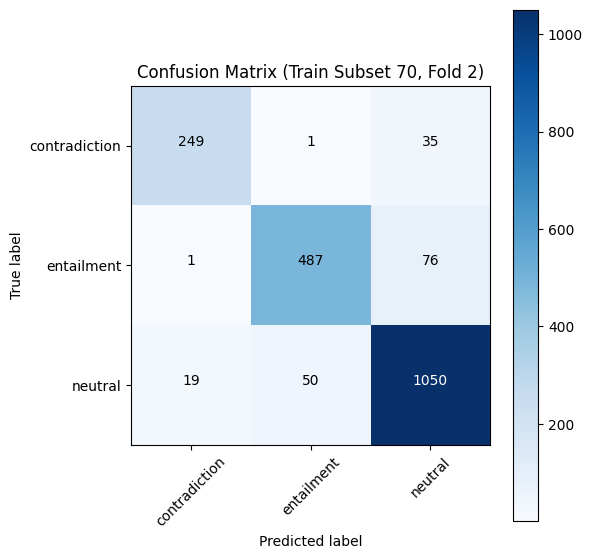

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24606.40 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.994400,0.928771,0.724466
2,0.958300,0.859481,0.848323
3,0.805700,0.801933,0.881860
4,0.732100,0.751782,0.892530
5,0.830800,0.707822,0.897866
6,0.670600,0.670837,0.894055
7,0.671300,0.638738,0.887957
8,0.696900,0.612592,0.879573
9,0.510500,0.590715,0.875000
10,0.511200,0.571406,0.868140


資料數量 70 的 Fold 3 Evaluation results: {'eval_loss': 0.4959132969379425, 'eval_accuracy': 0.8586128048780488, 'eval_runtime': 13.1864, 'eval_samples_per_second': 198.993, 'eval_steps_per_second': 6.219, 'epoch': 20.0}
分類報告 (Train Subset 70, Fold 3):
               precision    recall  f1-score   support

contradiction       0.97      0.53      0.68       285
   entailment       0.88      0.89      0.89       564
      neutral       0.84      0.94      0.89      1119

     accuracy                           0.86      1968
    macro avg       0.90      0.78      0.82      1968
 weighted avg       0.87      0.86      0.86      1968

Confusion Matrix (Train Subset 70, Fold 3):
[[ 150    1  134]
 [   0  502   62]
 [   5   67 1047]]


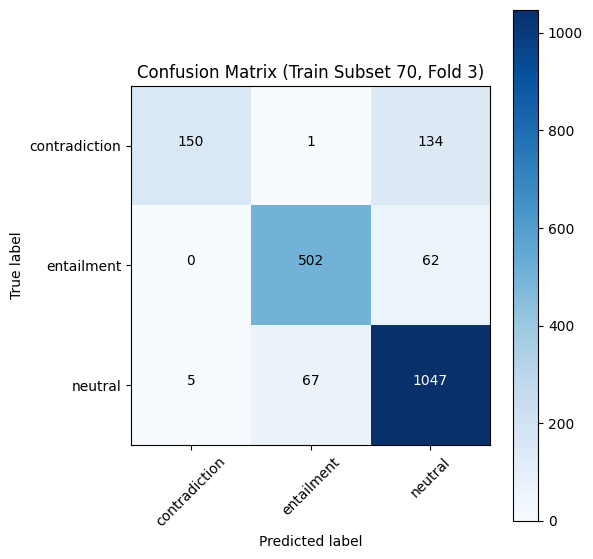


使用訓練資料數量: 100 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23466.79 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.786100,0.906024,0.706936
2,0.858000,0.816284,0.834985
3,0.856100,0.740358,0.873857
4,0.760800,0.675470,0.889101
5,0.745800,0.621615,0.894817
6,0.457600,0.576427,0.902058
7,0.562400,0.538928,0.904726
8,0.706600,0.507497,0.905869
9,0.405400,0.481344,0.907774
10,0.438200,0.460626,0.908918


資料數量 100 的 Fold 1 Evaluation results: {'eval_loss': 0.3822205662727356, 'eval_accuracy': 0.9134908536585366, 'eval_runtime': 13.3183, 'eval_samples_per_second': 197.023, 'eval_steps_per_second': 6.157, 'epoch': 20.0}
分類報告 (Train Subset 100, Fold 1):
               precision    recall  f1-score   support

contradiction       0.93      0.87      0.90       285
   entailment       0.91      0.86      0.89       564
      neutral       0.90      0.94      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.92      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 100, Fold 1):
[[ 247    1   37]
 [   1  487   76]
 [  17   45 1057]]


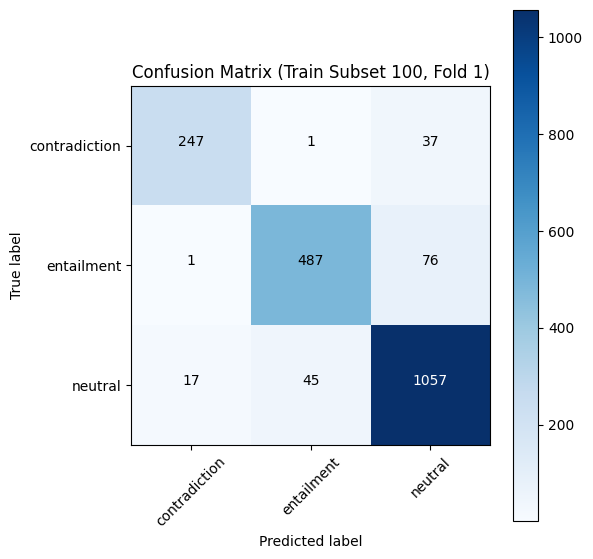

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24263.61 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.951900,0.904827,0.716845
2,0.823400,0.812802,0.851753
3,0.723500,0.735333,0.884527
4,0.746800,0.670067,0.897485
5,0.599300,0.615794,0.901677
6,0.761800,0.571573,0.901296
7,0.496700,0.535051,0.900534
8,0.605300,0.505758,0.900152
9,0.515000,0.482042,0.901296
10,0.387600,0.461926,0.900534


資料數量 100 的 Fold 2 Evaluation results: {'eval_loss': 0.3889406621456146, 'eval_accuracy': 0.9043445121951219, 'eval_runtime': 13.1769, 'eval_samples_per_second': 199.136, 'eval_steps_per_second': 6.223, 'epoch': 20.0}
分類報告 (Train Subset 100, Fold 2):
               precision    recall  f1-score   support

contradiction       0.93      0.86      0.89       285
   entailment       0.90      0.87      0.89       564
      neutral       0.91      0.94      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.91      0.89      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 100, Fold 2):
[[ 244    1   40]
 [   1  493   70]
 [  17   51 1051]]


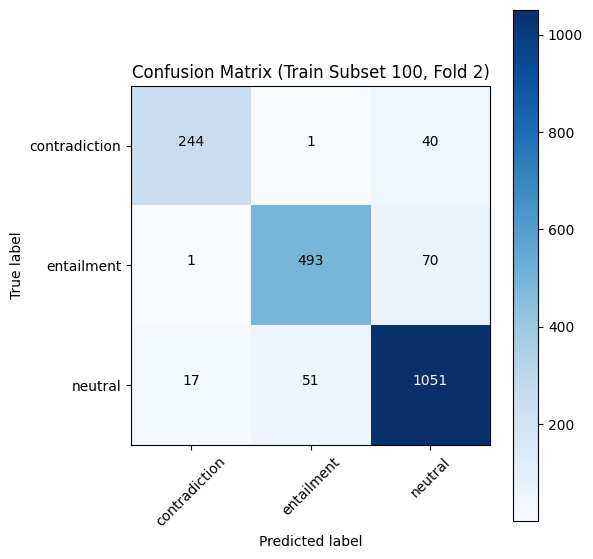

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24858.95 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.181000,0.898822,0.756860
2,0.885700,0.810431,0.873857
3,0.719800,0.736092,0.894055
4,0.673800,0.672803,0.896723
5,0.729100,0.620878,0.896723
6,0.531400,0.580124,0.897104
7,0.463800,0.545995,0.891768
8,0.456000,0.518009,0.889482
9,0.539800,0.493518,0.892530
10,0.440300,0.474040,0.892149


資料數量 100 的 Fold 3 Evaluation results: {'eval_loss': 0.4042593836784363, 'eval_accuracy': 0.8971036585365854, 'eval_runtime': 13.207, 'eval_samples_per_second': 198.682, 'eval_steps_per_second': 6.209, 'epoch': 20.0}
分類報告 (Train Subset 100, Fold 3):
               precision    recall  f1-score   support

contradiction       0.96      0.76      0.85       285
   entailment       0.89      0.88      0.89       564
      neutral       0.89      0.94      0.91      1119

     accuracy                           0.90      1968
    macro avg       0.91      0.86      0.88      1968
 weighted avg       0.90      0.90      0.90      1968

Confusion Matrix (Train Subset 100, Fold 3):
[[ 217    1   67]
 [   1  496   67]
 [   9   59 1051]]


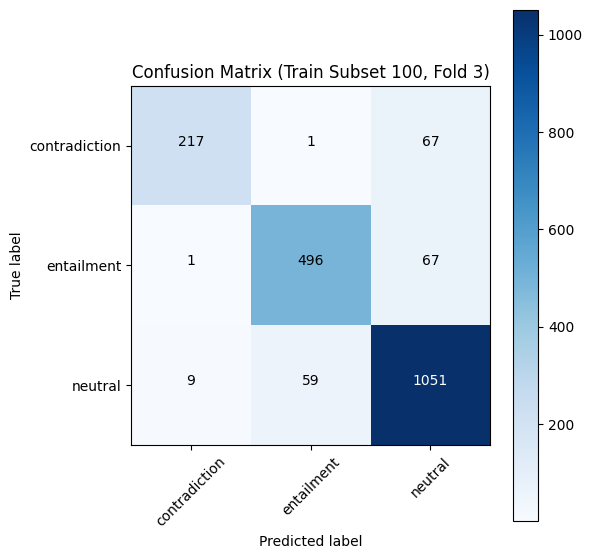


使用訓練資料數量: 300 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 21868.82 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.946800,0.737092,0.879954
2,0.599900,0.566240,0.907774
3,0.506200,0.452446,0.911966
4,0.332600,0.381978,0.913491
5,0.308800,0.336220,0.913872
6,0.296300,0.307228,0.914634
7,0.400000,0.287899,0.914253
8,0.440900,0.275226,0.914253
9,0.346400,0.265833,0.915396
10,0.466900,0.259766,0.915777


資料數量 300 的 Fold 1 Evaluation results: {'eval_loss': 0.24512986838817596, 'eval_accuracy': 0.9161585365853658, 'eval_runtime': 13.4372, 'eval_samples_per_second': 195.278, 'eval_steps_per_second': 6.102, 'epoch': 20.0}
分類報告 (Train Subset 300, Fold 1):
               precision    recall  f1-score   support

contradiction       0.89      0.89      0.89       285
   entailment       0.89      0.90      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 300, Fold 1):
[[ 255    1   29]
 [   1  505   58]
 [  32   60 1027]]


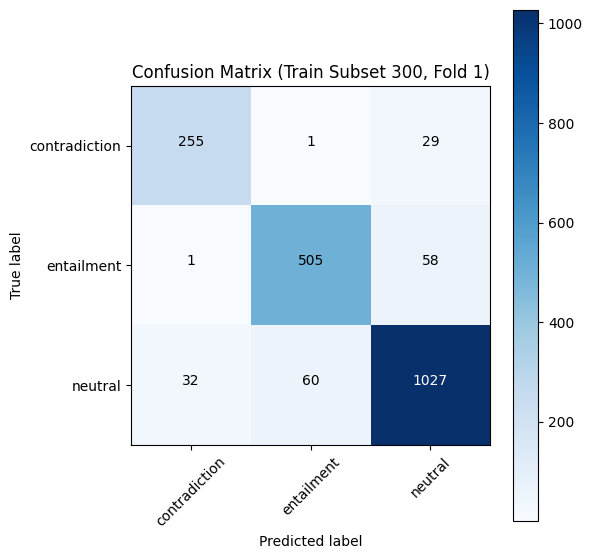

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 22213.14 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.795300,0.740984,0.879954
2,0.670900,0.569664,0.903582
3,0.505500,0.455976,0.900915
4,0.353600,0.388121,0.905488
5,0.547200,0.345339,0.905869
6,0.305100,0.318654,0.905107
7,0.506800,0.301283,0.904726
8,0.272800,0.289870,0.904726
9,0.268100,0.282094,0.905107
10,0.156900,0.277101,0.904345


資料數量 300 的 Fold 2 Evaluation results: {'eval_loss': 0.2647535502910614, 'eval_accuracy': 0.9043445121951219, 'eval_runtime': 13.6528, 'eval_samples_per_second': 192.195, 'eval_steps_per_second': 6.006, 'epoch': 20.0}
分類報告 (Train Subset 300, Fold 2):
               precision    recall  f1-score   support

contradiction       0.90      0.90      0.90       285
   entailment       0.90      0.89      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 300, Fold 2):
[[ 257    1   27]
 [   1  501   62]
 [  29   56 1034]]


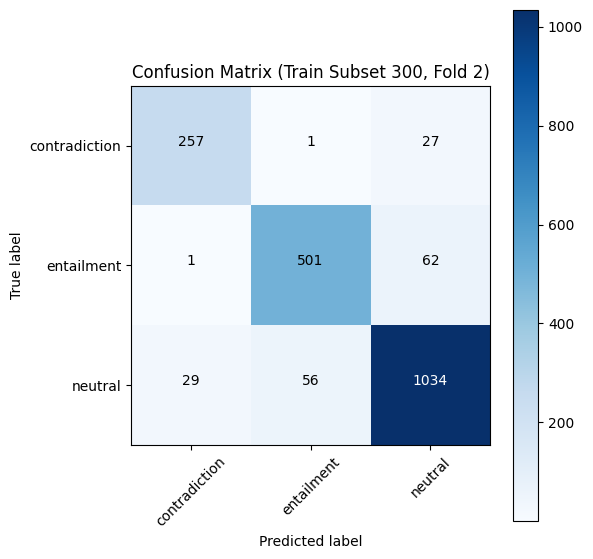

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24171.96 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.790000,0.758280,0.878430
2,0.680300,0.581154,0.901296
3,0.835000,0.467020,0.907774
4,0.547300,0.400892,0.904726
5,0.387700,0.358191,0.903582
6,0.451200,0.327871,0.904345
7,0.394800,0.307965,0.905488
8,0.404700,0.295124,0.905488
9,0.322800,0.284553,0.905488
10,0.256700,0.278126,0.905488


資料數量 300 的 Fold 3 Evaluation results: {'eval_loss': 0.25962182879447937, 'eval_accuracy': 0.9058689024390244, 'eval_runtime': 13.6861, 'eval_samples_per_second': 191.727, 'eval_steps_per_second': 5.991, 'epoch': 20.0}
分類報告 (Train Subset 300, Fold 3):
               precision    recall  f1-score   support

contradiction       0.88      0.91      0.89       285
   entailment       0.89      0.89      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 300, Fold 3):
[[ 258    1   26]
 [   1  503   60]
 [  33   61 1025]]


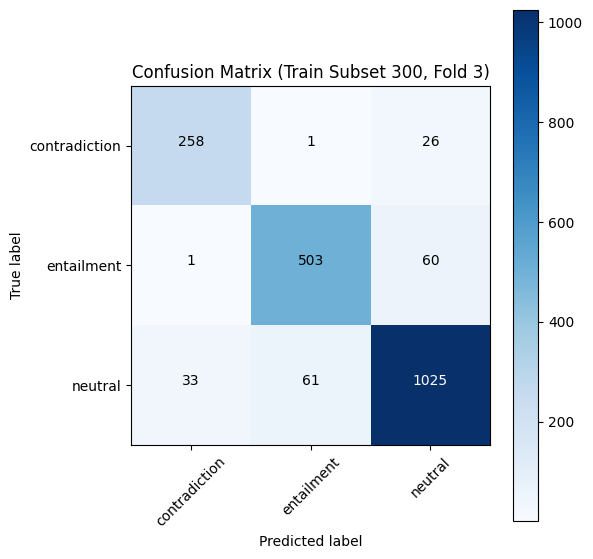


使用訓練資料數量: 1000 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 24691.09 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.632000,0.399560,0.912348
2,0.182600,0.270472,0.913872
3,0.237400,0.246620,0.914634
4,0.042800,0.242423,0.914253
5,0.092900,0.241096,0.915396
6,0.397300,0.240065,0.915777
7,0.034400,0.239152,0.916159
8,0.306800,0.240604,0.916159
9,0.117300,0.240389,0.915396
10,0.346800,0.241023,0.915396


資料數量 1000 的 Fold 1 Evaluation results: {'eval_loss': 0.23915241658687592, 'eval_accuracy': 0.9161585365853658, 'eval_runtime': 13.1049, 'eval_samples_per_second': 200.23, 'eval_steps_per_second': 6.257, 'epoch': 12.0}
分類報告 (Train Subset 1000, Fold 1):
               precision    recall  f1-score   support

contradiction       0.88      0.91      0.89       285
   entailment       0.90      0.89      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.91      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 1000, Fold 1):
[[ 258    1   26]
 [   1  503   60]
 [  33   58 1028]]


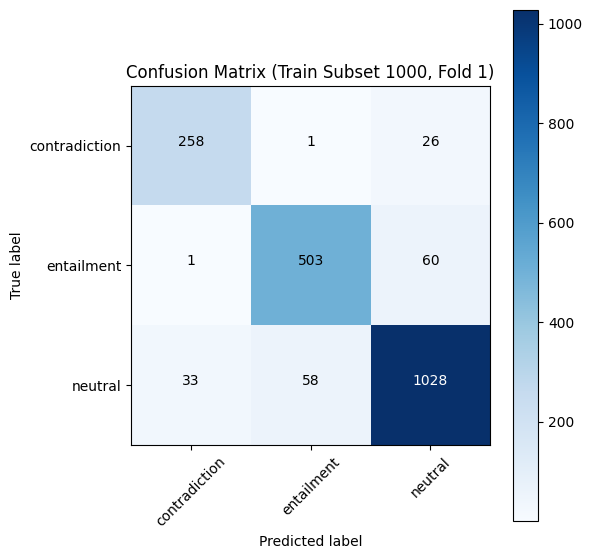

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 21572.96 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.663800,0.462383,0.899771
2,0.375500,0.304224,0.901677
3,0.952700,0.275588,0.899771
4,0.262900,0.269400,0.903963
5,0.199600,0.268580,0.903582
6,0.495500,0.267202,0.903963
7,0.262200,0.268539,0.904345
8,0.304600,0.268461,0.903582
9,0.292800,0.268475,0.903963
10,0.268700,0.269363,0.903963


資料數量 1000 的 Fold 2 Evaluation results: {'eval_loss': 0.26720210909843445, 'eval_accuracy': 0.9039634146341463, 'eval_runtime': 13.4715, 'eval_samples_per_second': 194.782, 'eval_steps_per_second': 6.087, 'epoch': 11.0}
分類報告 (Train Subset 1000, Fold 2):
               precision    recall  f1-score   support

contradiction       0.89      0.90      0.89       285
   entailment       0.89      0.90      0.89       564
      neutral       0.92      0.91      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 1000, Fold 2):
[[ 257    1   27]
 [   1  505   58]
 [  32   64 1023]]


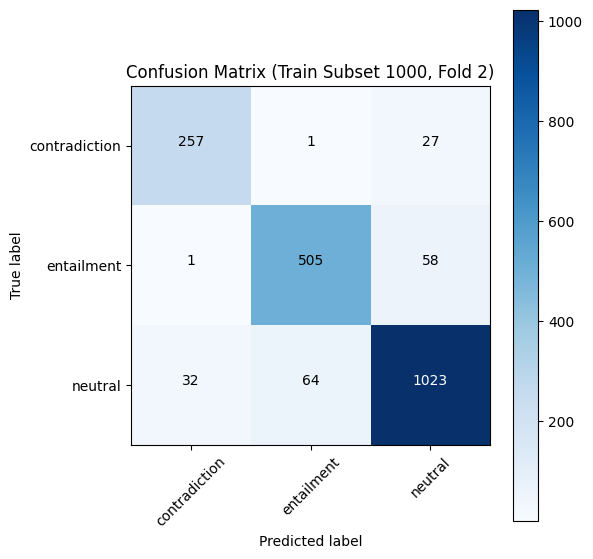

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23840.36 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.341300,0.444449,0.905869
2,0.338300,0.285192,0.907393
3,0.092200,0.252209,0.910061
4,0.348300,0.244776,0.905869
5,0.304300,0.243226,0.907012
6,0.071900,0.243002,0.907393
7,0.502100,0.242075,0.908537
8,0.616300,0.241727,0.909299
9,0.389400,0.242311,0.906631
10,0.581000,0.243717,0.908918


資料數量 1000 的 Fold 3 Evaluation results: {'eval_loss': 0.23908618092536926, 'eval_accuracy': 0.9092987804878049, 'eval_runtime': 13.4347, 'eval_samples_per_second': 195.315, 'eval_steps_per_second': 6.104, 'epoch': 20.0}
分類報告 (Train Subset 1000, Fold 3):
               precision    recall  f1-score   support

contradiction       0.87      0.91      0.89       285
   entailment       0.90      0.89      0.90       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 1000, Fold 3):
[[ 258    1   26]
 [   1  504   59]
 [  39   56 1024]]


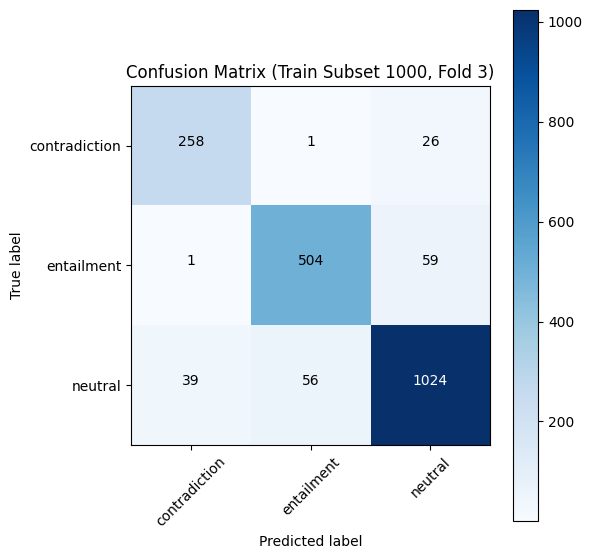


使用訓練資料數量: 7872 筆
Fold 1


Map: 100%|██████████| 2624/2624 [00:00<00:00, 22867.60 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388800,0.240419,0.915396
2,0.172000,0.238620,0.912729
3,0.082800,0.235925,0.912348
4,0.271800,0.237407,0.912348
5,0.821500,0.236730,0.913491
6,0.539400,0.232150,0.915015
7,0.051000,0.231829,0.913872
8,0.253000,0.232478,0.914634
9,0.390200,0.229726,0.916159
10,0.234300,0.231889,0.915396


資料數量 7872 的 Fold 1 Evaluation results: {'eval_loss': 0.22866547107696533, 'eval_accuracy': 0.9173018292682927, 'eval_runtime': 13.1957, 'eval_samples_per_second': 198.853, 'eval_steps_per_second': 6.214, 'epoch': 18.0}
分類報告 (Train Subset 7872, Fold 1):
               precision    recall  f1-score   support

contradiction       0.89      0.91      0.90       285
   entailment       0.90      0.90      0.90       564
      neutral       0.93      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.91      0.91      0.91      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 7872, Fold 1):
[[ 260    1   24]
 [   1  505   58]
 [  30   58 1031]]


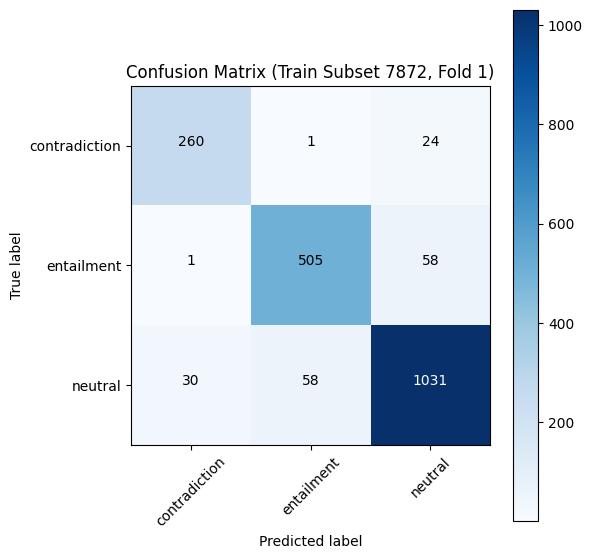

Fold 2


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23704.08 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.572800,0.264677,0.900534
2,0.195500,0.268780,0.899771
3,0.386500,0.273406,0.900534
4,0.237000,0.268444,0.902439
5,0.081200,0.264365,0.902058
6,0.258500,0.261747,0.902820
7,0.218600,0.264553,0.903963
8,0.266400,0.263313,0.903582
9,0.186300,0.262840,0.903201
10,0.194100,0.259492,0.903582


資料數量 7872 的 Fold 2 Evaluation results: {'eval_loss': 0.25926119089126587, 'eval_accuracy': 0.9039634146341463, 'eval_runtime': 13.1989, 'eval_samples_per_second': 198.804, 'eval_steps_per_second': 6.213, 'epoch': 16.0}
分類報告 (Train Subset 7872, Fold 2):
               precision    recall  f1-score   support

contradiction       0.88      0.91      0.90       285
   entailment       0.89      0.90      0.89       564
      neutral       0.93      0.91      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.91      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 7872, Fold 2):
[[ 259    1   25]
 [   2  507   55]
 [  32   64 1023]]


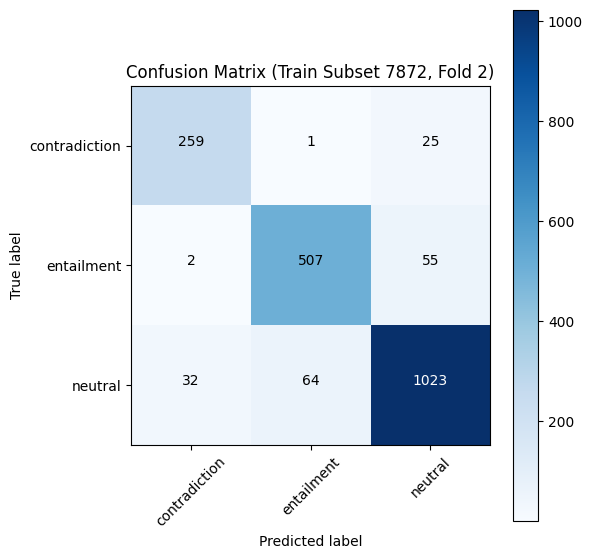

Fold 3


Map: 100%|██████████| 2624/2624 [00:00<00:00, 23897.56 examples/s]
/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_32557/2876817202.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.437500,0.246580,0.906631
2,0.074200,0.247943,0.908155
3,0.226500,0.242930,0.911585
4,0.342200,0.245760,0.909680
5,0.410800,0.238204,0.913872
6,0.087300,0.233071,0.911966
7,0.527800,0.235109,0.914634
8,0.165400,0.232665,0.914253
9,0.358400,0.236515,0.915015
10,0.232400,0.232732,0.915396


資料數量 7872 的 Fold 3 Evaluation results: {'eval_loss': 0.22898425161838531, 'eval_accuracy': 0.9138719512195121, 'eval_runtime': 13.1655, 'eval_samples_per_second': 199.309, 'eval_steps_per_second': 6.228, 'epoch': 19.0}
分類報告 (Train Subset 7872, Fold 3):
               precision    recall  f1-score   support

contradiction       0.89      0.91      0.90       285
   entailment       0.89      0.90      0.89       564
      neutral       0.93      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.91      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 7872, Fold 3):
[[ 258    1   26]
 [   1  507   56]
 [  32   62 1025]]


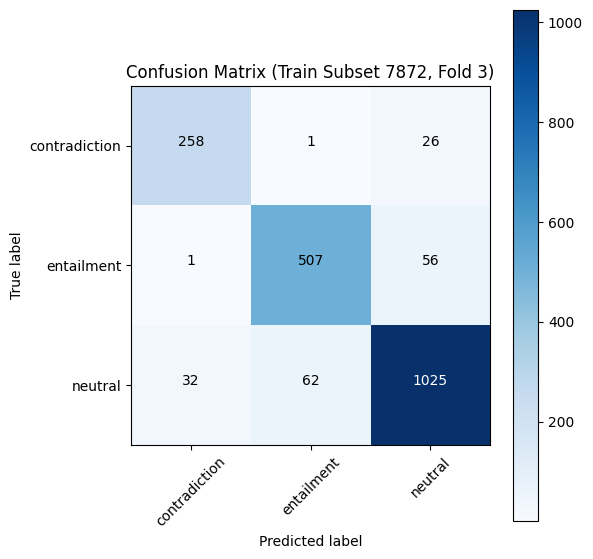

Accuracy Summary:
   train_samples  test_accuracy
0             20       0.800940
1             50       0.897485
2             70       0.890879
3            100       0.904980
4            300       0.908791
5           1000       0.909807
6           7872       0.911712


In [37]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_dataset)]
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
accuracy_summary = []

train_dataset = train_df.reset_index(drop=True)

for size in sample_sizes:
    print(f"\n使用訓練資料數量: {size} 筆")
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f"Fold {fold + 1}")
        train_subset = train_dataset.loc[train_idx].reset_index(drop=True).head(size)
        val_subset = train_dataset.loc[val_idx].reset_index(drop=True)
        
        # Tokenize the subsets
        train_subset = Dataset.from_pandas(train_subset).map(tokenize_function, batched=True)
        val_subset = Dataset.from_pandas(val_subset).map(tokenize_function, batched=True)
        
        train_subset = train_subset.map(rename_label)
        val_subset = val_subset.map(rename_label)
        
        train_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        val_subset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
        
        model = CustomDebertaClassifier(model_name=model_name, num_labels=num_labels, dropout_rate=0.1)
        model.to(device)
        
        training_args = TrainingArguments(
            output_dir=f"/mnt/d/Weight/results_{size}_fold_{fold + 1}",
            evaluation_strategy="epoch",
            learning_rate=2e-5,
            save_strategy="epoch",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=20,
            weight_decay=0.01,
            logging_steps=1,
            load_best_model_at_end=True,
            remove_unused_columns=False,
            logging_dir=f"/mnt/d/Weight/logs_{size}_fold_{fold + 1}",
        )
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=val_subset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
        )
        
        trainer.train()
        
        eval_results = trainer.evaluate()
        print(f"資料數量 {size} 的 Fold {fold + 1} Evaluation results:", eval_results)
        
        predictions_output = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions_output.predictions, axis=-1)
        
        print(f"分類報告 (Train Subset {size}, Fold {fold + 1}):")
        target_names = [k for k, v in sorted(label2id.items(), key=lambda item: item[1])]
        print(classification_report(test_dataset["labels"].numpy(), predicted_labels, target_names=target_names))
        
        fold_accuracies.append(eval_results["eval_accuracy"])
        
        # 混淆矩陣
        cm = confusion_matrix(test_dataset['labels'], predicted_labels)
        print(f"Confusion Matrix (Train Subset {size}, Fold {fold + 1}):")
        print(cm)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix (Train Subset {size}, Fold {fold + 1})")
        plt.colorbar()
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    
    mean_accuracy = np.mean(fold_accuracies)
    accuracy_summary.append({"train_samples": size, "test_accuracy": mean_accuracy})


summary_df = pd.DataFrame(accuracy_summary)
print("Accuracy Summary:")
print(summary_df)
